In [179]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from sklearn.cluster import MiniBatchKMeans, KMeans
import setGPU
import numpy as np
import h5py

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import setGPU

import sys,os
#sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('IDEC/')))
import idec_graph as idec_mod
reload(idec_mod)
from idec_graph import IDEC
import IDEC.utils as utils_idec
reload(utils_idec)
from scipy.sparse import csr_matrix

from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from IDEC.utils import GraphDataset, cluster_acc
from torch_scatter import scatter_mean,scatter_max

from sklearn.manifold import TSNE

import matplotlib.colors as colors

In [176]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/inputs/'
TRAIN_NAME = 'background_chan3_passed_ae_l1.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
file_dataset = np.array(in_file['dataset'][:,:,:])
file_dataset[:,:,2] = file_dataset[:,:,2]/1e5
file_dataset[:,:,3] = file_dataset[:,:,3]/1e5

n_proc = 3
(unique, counts) = np.unique(file_dataset[:,:,0], return_counts=True)
procs_sorted, counts_sorted = zip(*sorted(zip(unique, counts), key=lambda x: x[1],reverse=True))
top_proc_mask = np.isin(file_dataset[:,0,0], procs_sorted[:n_proc]) #choose top 3
file_dataset = file_dataset[top_proc_mask][:,0:12,:]
file_dataset[:,:,2] = np.log(file_dataset[:,:,2]+1)
file_dataset[:,:,3] = np.log(file_dataset[:,:,3]+1)

datas = []
tot_evt =  file_dataset.shape[0]# int(1e4)
print('Preparing the dataset of {} events'.format(tot_evt))
n_objs = 11
#adj = [csr_matrix(np.ones((n_objs,n_objs)) - np.eye(n_objs))]*tot_evt
#edge_index = [from_scipy_sparse_matrix(a)[0] for a in adj]     
adj_non_con = make_adjacencies(file_dataset[:,1:,:])
adj_non_connected = [csr_matrix(adj_non_con[i]) for i in range(tot_evt)]
edge_index = [from_scipy_sparse_matrix(a)[0] for a in adj_non_connected] 

x = [torch.tensor(file_dataset[i_evt,1:,1:], dtype=torch.float) for i_evt in range(tot_evt)]
y = [torch.tensor(int(file_dataset[i_evt,0,0]), dtype=torch.int) for i_evt in range(tot_evt)]
met = [torch.tensor(file_dataset[i_evt,0,[2,5]], dtype=torch.float) for i_evt in range(tot_evt)]
datas = [Data(x=x_event, edge_index=edge_index_event,y=torch.unsqueeze(y_event, 0),x_met=met_event) 
    for x_event,edge_index_event,y_event,met_event in zip(x,edge_index,y,met)]
print('Dataset of {} events prepared'.format(tot_evt))
dataset  = GraphDataset(datas)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Preparing the dataset of 62305 events
Dataset of 62305 events prepared


In [180]:
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


num_clusters_dict = {}

for num_cluster in [3]:  
    model = IDEC(input_shape = [11,5], 
                hidden_channels = [10, 12, 16, 20, 25, 30,40],
                latent_dim =5,
                n_clusters=num_cluster,
                alpha=1,
                pretrain_path='data_graph/graph_ae_pretrain.pkl'
    ).to(device)

    model.load_state_dict(torch.load(
"/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/IDEC/data_graph/graph_ae_pretrain_top_3_emb_log_real_part_huber_met_fullmodel_num_clust_{}.pkl".format(num_cluster)))

    batch_size=256
    test_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    latent_pred = []
    true_labels = []
    model.eval() 
    
    pred_features = np.array([model.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
    pred_features_met = np.array([model.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
    emb_input = []  
    #for i,d in enumerate(test_loader):
    #    model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))
    #    emb_input.append(model.ae.embedded_input.detach().cpu())
    #emb_input = np.array(emb_input)

    acc, nmi, ari,reassignment, true_labels, pred_labels, latent_pred  = model.validateOnCompleteTestData(test_loader)

    print('Acc {:.4f}'.format(acc),
        ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
    predicted_reassigned = np.array([reassignment[item] for item in pred_labels])
    
    idx = np.random.choice(list(range(latent_pred.shape[0])), 3000)
    num_clusters_dict[num_cluster] = {}
    num_clusters_dict[num_cluster]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])

    

Acc 0.5396 , nmi 0.3030 , ari 0.2942


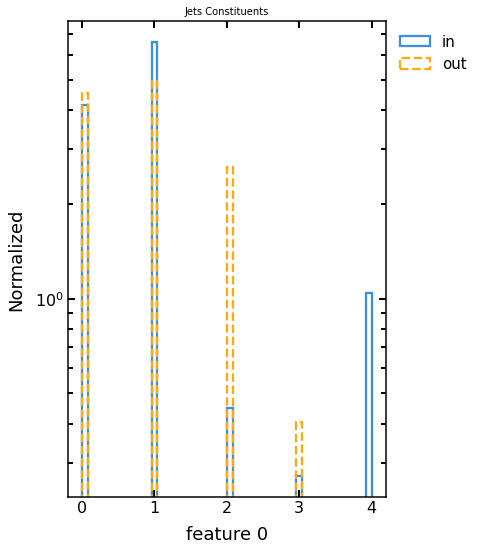

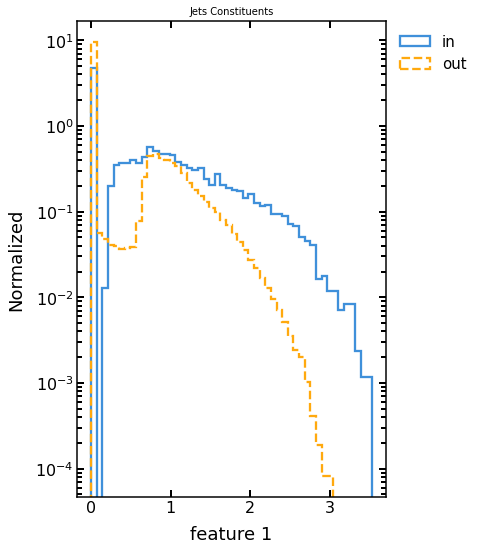

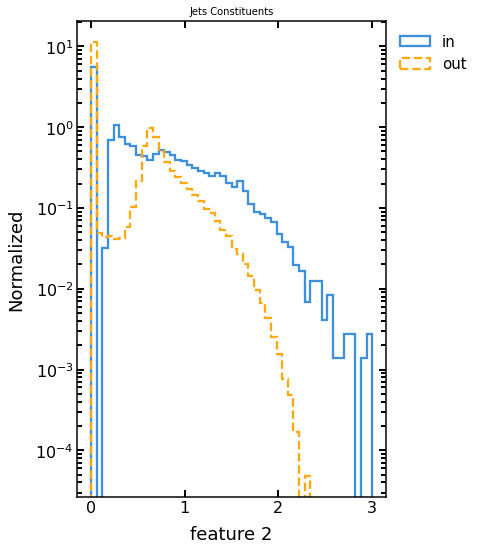

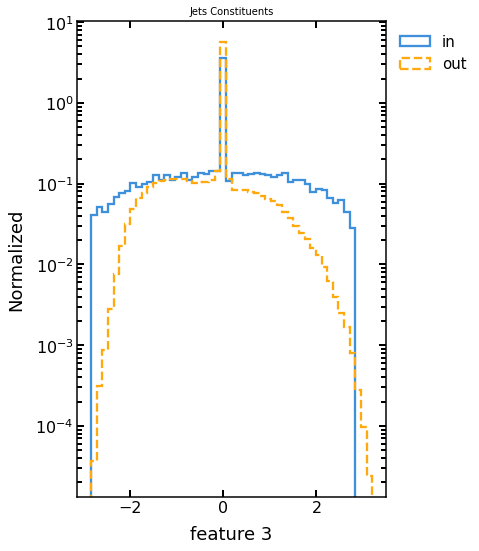

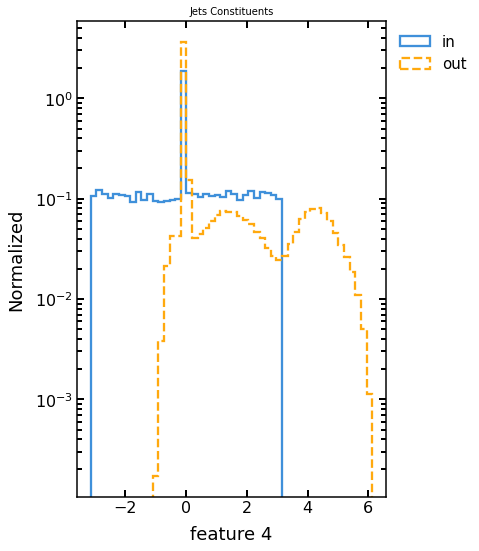

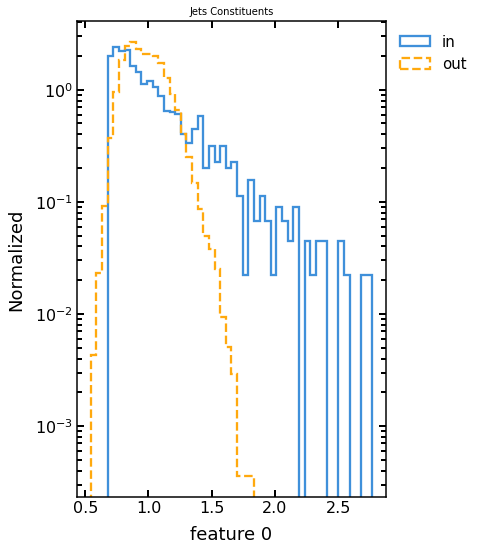

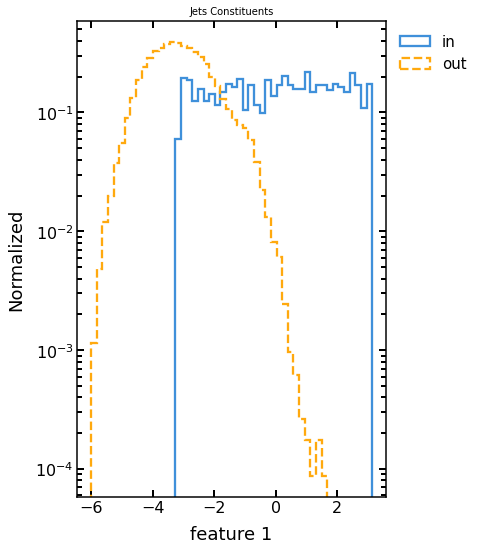

In [200]:
sys.path.append(os.path.abspath(os.path.join('../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)

#t = file_dataset[:int(1e3),:,2:]
#t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

#t = np.vstack(emb_input)

t = file_dataset[:int(1e3),:,1:]
t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

pred_features = np.array([model.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
pred_features_small = pred_features[:,:,4:]

pr_f = np.expand_dims(np.argmax(np.exp(pred_features[:,:,0:4]),axis=-1),axis=-1)
pred_features_small = np.concatenate([pr_f,pred_features[:,:,4:]],axis=-1)

pred_features_2 = pred_features_small.reshape((pred_features_small.shape[0])*pred_features_small.shape[1],pred_features_small.shape[2])

t_met = file_dataset[:int(1e3),0:1,[2,5]]
t_met = t_met.reshape((t_met.shape[0])*t_met.shape[1],t_met.shape[2])
pred_met = pred_features_met.reshape((pred_features_met.shape[0]*pred_features_met.shape[1],pred_features_met.shape[2]))

vande_plot.plot_features([t,pred_features_2], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    
vande_plot.plot_features([t_met,pred_met], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    

In [6]:
X_embedded = TSNE(n_components=2,verbose=1, perplexity=20, n_iter=1000, learning_rate=200
                 ).fit_transform(latent_pred[idx])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.002s...
[t-SNE] Computed neighbors for 3000 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.663431
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.942154
[t-SNE] KL divergence after 1000 iterations: 0.916972


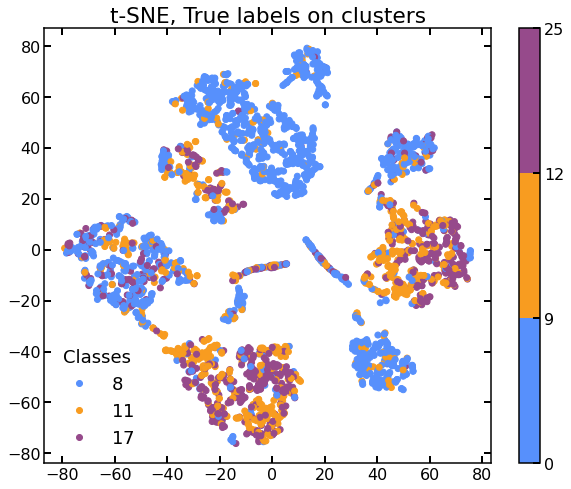

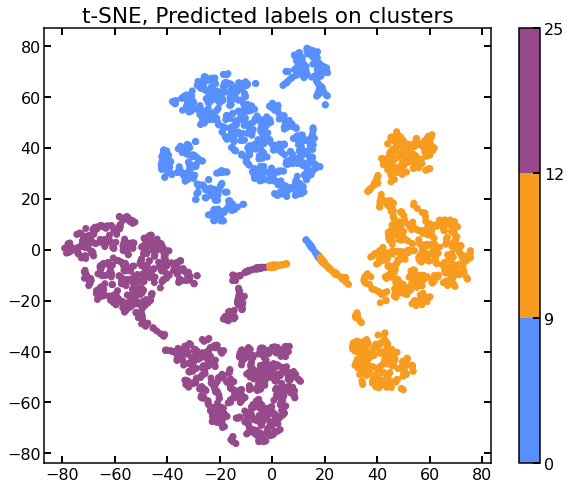

In [7]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


cmap = plt.cm.rainbow #rainbow
cmap = (colors.ListedColormap(['#5790fc', '#f89c20', '#e42536', '#964a8b'])
        .with_extremes(over='0.25', under='0.75'))
#norm = colors.BoundaryNorm(np.arange(1, 26, 1), cmap.N)
norm = colors.BoundaryNorm([0,9,12,25], cmap.N)

fig = plt.figure(figsize=(10,8))

#top_proc_mask = np.isin(true_labels[idx], result1[:5])
scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1], c=true_labels[idx],cmap=cmap, norm=norm)
plt.title('t-SNE, True labels on clusters')
cb = plt.colorbar()
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

#ax.add_artist(legend1)


fig = plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=np.array(predicted_reassigned)[idx],cmap=cmap, norm=norm)
plt.title('t-SNE, Predicted labels on clusters')
cb = plt.colorbar()

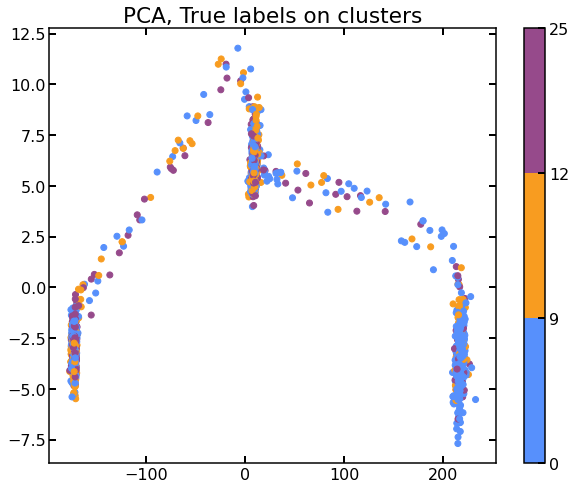

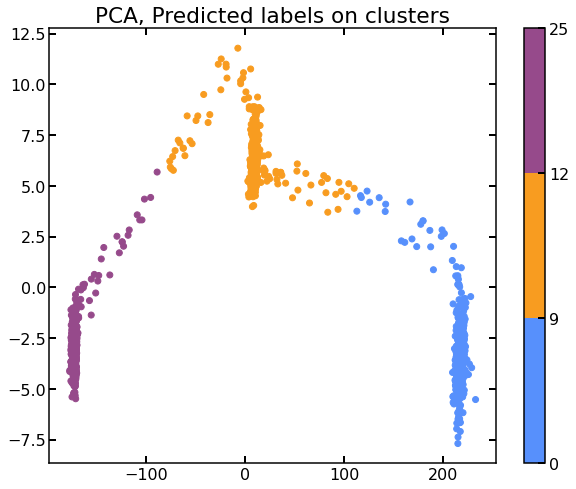

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import colors


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(latent_pred))

pc1 = principalComponents[:,0][idx]
pc2 = principalComponents[:,1][idx]




fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=true_labels[idx],cmap=cmap, norm=norm, marker='o')
plt.title('PCA, True labels on clusters')
cb = plt.colorbar()



fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=predicted_reassigned[idx],cmap=cmap, norm=norm)
plt.title('PCA, Predicted labels on clusters')
cb = plt.colorbar()



In [9]:
np.unique(predicted_reassigned)

array([ 8, 11, 17])

In [92]:
np.max(file_dataset[:,1,3])

34.1036

In [43]:
pred_features[0:2,0:4,:].shape

(2, 4, 5)

In [44]:
test = pred_features[0:2,0:4,:].reshape(2,20)


In [45]:
test

array([[-2.31592217e-04,  8.45707254e-04, -6.63897023e-04,
         6.87253269e-05, -6.48455753e-04, -5.96069382e-04,
         1.09805353e-03, -9.42248153e-04,  7.45501311e-05,
         1.26274896e-03, -1.30580505e-04,  1.66248623e-03,
        -8.63827998e-04,  6.86618441e-05, -1.35476911e-03,
         3.87722044e-04,  1.41494675e-03, -9.19922721e-04,
         6.81375677e-05, -8.41366185e-04],
       [ 1.11468520e-03,  1.07218046e-04, -1.48488022e-03,
         1.46042403e-05, -1.03838311e-03,  2.40564113e-05,
         2.40233494e-04, -1.34916813e-03,  2.24452378e-05,
         2.89878808e-05,  1.73368654e-03, -2.52388883e-04,
        -2.27108155e-03,  1.75628120e-05, -1.44816504e-03,
         2.36086082e-03,  4.95023560e-04, -2.17854278e-03,
         2.23907300e-05, -2.21140683e-03]], dtype=float32)

In [46]:
test.reshape(2*4,5)

array([[-2.31592217e-04,  8.45707254e-04, -6.63897023e-04,
         6.87253269e-05, -6.48455753e-04],
       [-5.96069382e-04,  1.09805353e-03, -9.42248153e-04,
         7.45501311e-05,  1.26274896e-03],
       [-1.30580505e-04,  1.66248623e-03, -8.63827998e-04,
         6.86618441e-05, -1.35476911e-03],
       [ 3.87722044e-04,  1.41494675e-03, -9.19922721e-04,
         6.81375677e-05, -8.41366185e-04],
       [ 1.11468520e-03,  1.07218046e-04, -1.48488022e-03,
         1.46042403e-05, -1.03838311e-03],
       [ 2.40564113e-05,  2.40233494e-04, -1.34916813e-03,
         2.24452378e-05,  2.89878808e-05],
       [ 1.73368654e-03, -2.52388883e-04, -2.27108155e-03,
         1.75628120e-05, -1.44816504e-03],
       [ 2.36086082e-03,  4.95023560e-04, -2.17854278e-03,
         2.23907300e-05, -2.21140683e-03]], dtype=float32)

In [52]:
test.reshape(2,4,5)

array([[[-2.31592217e-04,  8.45707254e-04, -6.63897023e-04,
          6.87253269e-05, -6.48455753e-04],
        [-5.96069382e-04,  1.09805353e-03, -9.42248153e-04,
          7.45501311e-05,  1.26274896e-03],
        [-1.30580505e-04,  1.66248623e-03, -8.63827998e-04,
          6.86618441e-05, -1.35476911e-03],
        [ 3.87722044e-04,  1.41494675e-03, -9.19922721e-04,
          6.81375677e-05, -8.41366185e-04]],

       [[ 1.11468520e-03,  1.07218046e-04, -1.48488022e-03,
          1.46042403e-05, -1.03838311e-03],
        [ 2.40564113e-05,  2.40233494e-04, -1.34916813e-03,
          2.24452378e-05,  2.89878808e-05],
        [ 1.73368654e-03, -2.52388883e-04, -2.27108155e-03,
          1.75628120e-05, -1.44816504e-03],
        [ 2.36086082e-03,  4.95023560e-04, -2.17854278e-03,
          2.23907300e-05, -2.21140683e-03]]], dtype=float32)

In [54]:
test.reshape(2,4,5)[0,1,:]

array([-5.9606938e-04,  1.0980535e-03, -9.4224815e-04,  7.4550131e-05,
        1.2627490e-03], dtype=float32)

In [55]:
torch.permute(test.reshape(2,4,5),dim=1)

TypeError: permute(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [58]:
x = torch.randn(2, 4, 5)
print(x)
idx = torch.randint(4, size=(2, 4))
permutated_x = x.gather(dim=1, index=idx.unsqueeze(-1).expand(x.shape))
print(permutated_x)
final_x = permutated_x.reshape(2*4,5)
print(final_x)
#torch.all(x[0][idx[0]] == permutated_x[0])
#torch.all(x[28][idx[28]] == permutated_x[28])

tensor([[[ 0.3026, -0.9815, -0.1987,  1.5485,  0.3916],
         [ 0.6833,  0.5835,  0.5342,  1.4889, -0.5616],
         [ 0.8107,  1.4139,  0.2739,  1.2392,  0.5606],
         [ 1.5068, -0.9406,  2.6684, -0.4557,  0.1885]],

        [[ 0.5117, -0.0191,  0.7737,  0.2579, -0.2908],
         [ 0.5810,  1.0884, -1.8448,  0.2572, -0.2779],
         [ 0.2472,  1.9303,  0.8531,  0.8472,  0.1965],
         [ 0.1247,  0.2278,  1.9604, -1.1994, -0.5521]]])
tensor([[[ 0.6833,  0.5835,  0.5342,  1.4889, -0.5616],
         [ 0.8107,  1.4139,  0.2739,  1.2392,  0.5606],
         [ 1.5068, -0.9406,  2.6684, -0.4557,  0.1885],
         [ 0.8107,  1.4139,  0.2739,  1.2392,  0.5606]],

        [[ 0.2472,  1.9303,  0.8531,  0.8472,  0.1965],
         [ 0.5117, -0.0191,  0.7737,  0.2579, -0.2908],
         [ 0.5117, -0.0191,  0.7737,  0.2579, -0.2908],
         [ 0.2472,  1.9303,  0.8531,  0.8472,  0.1965]]])


In [13]:
batch_size=256
test_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, drop_last=True)

/afs/cern.ch/user/n/nchernya/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [80]:
for i,d in enumerate(test_loader):
    test_x = d.x[:,0]
    break

In [68]:
embedding = nn.Embedding(num_embeddings=5, embedding_dim=2)


In [65]:
vocab_size = 5
test_simple = torch.squeeze(test_x)
encoded_pid = [F.one_hot(d.type(torch.LongTensor),vocab_size) for d in test_simple]

In [133]:
testing_emb = embedding(test_x.type(torch.LongTensor))

In [81]:
test_x.shape

torch.Size([4352])

In [88]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [112]:
np.vstack(emb_input).shape

(1057536, 6)

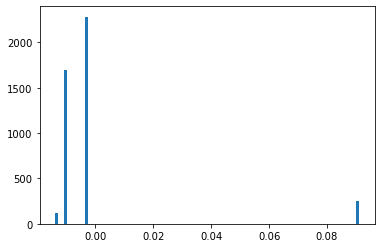

In [128]:
_ = plt.hist(emb_input[0][:,0].numpy(),bins=100)

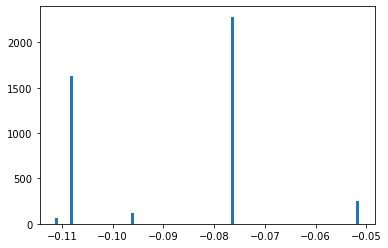

In [129]:
_ = plt.hist(emb_input[0][:,1].numpy(),bins=100)

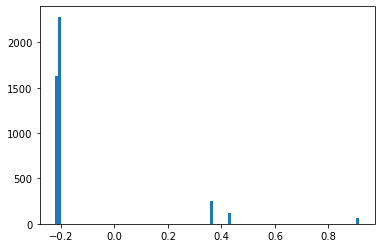

In [135]:
_ = plt.hist(testing_emb[:,0].detach().cpu().numpy(),bins=100)

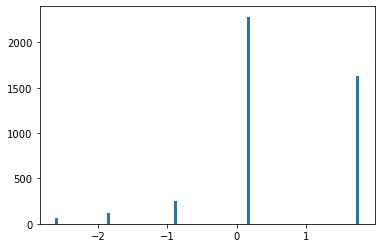

In [136]:
_ = plt.hist(testing_emb[:,1].detach().cpu().numpy(),bins=100)

In [291]:
from torch_geometric.utils import from_scipy_sparse_matrix, to_dense_batch

eps = 1e-12

def pairwise_distance(x, y):
    if (x.shape[0] != y.shape[0]):
        raise ValueError(f"The batch size of x and y are not equal! x.shape[0] is {x.shape[0]}, whereas y.shape[0] is {y.shape[0]}!")
    if (x.shape[-1] != y.shape[-1]):
        raise ValueError(f"Feature dimension of x and y are not equal! x.shape[-1] is {x.shape[-1]}, whereas y.shape[-1] is {y.shape[-1]}!")


    batch_size = x.shape[0]
    num_row = x.shape[1]
    num_col = y.shape[1]
    vec_dim = x.shape[-1]

    x1 = x.repeat(1, 1, num_col).view(batch_size, -1, num_col, vec_dim).to(device)
    y1 = y.repeat(1, num_row, 1).view(batch_size, num_row, -1, vec_dim).to(device)

    dist = torch.norm(x1 - y1 + eps, dim=-1)

    return dist
        
def chamfer_loss(target, reco, batch):
    x = to_dense_batch(target, batch)[0]
    y = to_dense_batch(reco, batch)[0] 
    dist = pairwise_distance(x,y)
    # For every output value, find its closest input value; for every input value, find its closest output value.
    min_dist_xy = torch.min(dist, dim = -1)  # Get min distance per row - Find the closest input to the output
    min_dist_yx = torch.min(dist, dim = -2)  # Get min distance per column - Find the closest output to the input
    print(torch.min(dist, dim = -2), torch.min(dist, dim = 1))
    
    xy_idx = min_dist_xy.indices.clone()
    yx_idx = min_dist_yx.indices.clone()  
    
    
    eucl =  torch.sum(min_dist_xy.values + min_dist_yx.values)
    batch_size = x.shape[0]*x.shape[1]
    return eucl/batch_size, xy_idx, yx_idx


In [292]:
for i,d in enumerate(test_loader):
    if i==1 : 
        another_data = d
        break
for i,d in enumerate(test_loader):
    loss,xy_idx, yx_idx = chamfer_loss(d.x, another_data.x,d.batch)
    break

torch.return_types.min(
values=tensor([[3.3171e+00, 2.6545e+00, 2.6439e+00,  ..., 2.2361e-12, 2.2361e-12,
         2.2361e-12],
        [3.6161e+00, 3.0424e+00, 3.3763e+00,  ..., 2.2361e-12, 2.2361e-12,
         2.2361e-12],
        [2.0370e+00, 3.5430e+00, 1.8517e+00,  ..., 2.2361e-12, 2.2361e-12,
         2.2361e-12],
        ...,
        [5.2191e-01, 6.2721e+00, 9.1121e+00,  ..., 2.2361e-12, 2.2361e-12,
         2.2361e-12],
        [1.0198e+00, 9.8827e+00, 2.8976e+00,  ..., 2.2361e-12, 2.2361e-12,
         2.2361e-12],
        [3.4167e+00, 2.8399e+00, 2.4609e+00,  ..., 2.2361e-12, 2.2361e-12,
         2.2361e-12]], device='cuda:0'),
indices=tensor([[ 0,  1,  1,  ..., 10, 10, 10],
        [ 1,  3,  1,  ...,  8,  8,  8],
        [ 0,  6,  6,  ...,  7,  7,  7],
        ...,
        [ 0,  1,  1,  ...,  6,  6,  6],
        [ 0,  1,  1,  ...,  7,  7,  7],
        [ 3,  3,  3,  ..., 11, 11, 11]], device='cuda:0')) torch.return_types.min(
values=tensor([[3.3171e+00, 2.6545e+00, 2.6439e+00,

In [299]:
len(d.batch)/len(torch.unique(d.batch))

17.0

In [210]:
yx_idx

tensor([[ 0,  1,  1,  ..., 10, 10, 10],
        [ 1,  3,  1,  ...,  8,  8,  8],
        [ 0,  6,  6,  ...,  7,  7,  7],
        ...,
        [ 0,  1,  1,  ...,  6,  6,  6],
        [ 0,  1,  1,  ...,  7,  7,  7],
        [ 3,  3,  3,  ..., 11, 11, 11]], device='cuda:0')

In [325]:
num_particles = 17
aux_idx = num_particles * torch.arange(batch_size).cuda() #We create auxiliary indices to separate per batch of particles
aux_idx = aux_idx.view(batch_size, 1)
aux_idx = torch.repeat_interleave(aux_idx, num_particles, axis=-1)


In [326]:
aux_idx.shape

torch.Size([256, 17])

In [337]:
idx1 = xy_idx + aux_idx

for i,d in enumerate(test_loader):
    idx1 = xy_idx + aux_idx
    idx2 = yx_idx + aux_idx
    get_x_int = torch.take(d.x[:], idx1.to('cpu').reshape((idx1.shape[0]*idx1.shape[1])).unsqueeze(1))

    break

In [356]:
a = d.x[idx1.to('cpu').reshape((idx1.shape[0]*idx1.shape[1]))][:,1]

In [357]:
b = torch.take(d.x[:,1], idx1.to('cpu').reshape((idx1.shape[0]*idx1.shape[1])))

In [358]:
(a==b).all()

tensor(True)

In [265]:
idx1.to('cpu').reshape((idx1.shape[0]*idx1.shape[1]))[0:34]

tensor([ 0,  2,  3,  6,  9,  5,  9,  5,  7,  7, 10, 10, 10, 10, 10, 10, 10, 18,
        20, 20, 18, 20, 24, 24, 19, 24, 24, 24, 24, 24, 24, 24, 24, 24])

In [278]:
a = torch.rand(batch_size,num_particles).to('cuda:0')


In [282]:
torch.take(a,yx_idx)

tensor([[0.0490, 0.7325, 0.7325,  ..., 0.7580, 0.7580, 0.7580],
        [0.7325, 0.1729, 0.7325,  ..., 0.6850, 0.6850, 0.6850],
        [0.0490, 0.6057, 0.6057,  ..., 0.9736, 0.9736, 0.9736],
        ...,
        [0.0490, 0.7325, 0.7325,  ..., 0.6057, 0.6057, 0.6057],
        [0.0490, 0.7325, 0.7325,  ..., 0.9736, 0.9736, 0.9736],
        [0.1729, 0.1729, 0.1729,  ..., 0.6220, 0.6220, 0.6220]],
       device='cuda:0')

In [280]:
torch.take(a,idx1)

tensor([[0.0490, 0.1944, 0.1729,  ..., 0.7580, 0.7580, 0.7580],
        [0.8858, 0.9318, 0.9318,  ..., 0.3816, 0.3816, 0.3816],
        [0.0666, 0.8167, 0.7163,  ..., 0.0060, 0.0060, 0.0060],
        ...,
        [0.3685, 0.6592, 0.6463,  ..., 0.0866, 0.0866, 0.0866],
        [0.2021, 0.4602, 0.5946,  ..., 0.3703, 0.3703, 0.3703],
        [0.1514, 0.7262, 0.6400,  ..., 0.2149, 0.2149, 0.2149]],
       device='cuda:0')

In [281]:
xy_idx

tensor([[ 0,  2,  3,  ..., 10, 10, 10],
        [ 1,  3,  3,  ...,  7,  7,  7],
        [ 0,  2,  1,  ...,  5,  5,  5],
        ...,
        [ 0,  1,  5,  ...,  6,  6,  6],
        [ 0,  2,  5,  ..., 10, 10, 10],
        [ 4,  3,  2,  ...,  6,  6,  6]], device='cuda:0')

In [323]:
num_particles = 17
aux_idx = num_particles * torch.arange(batch_size).cuda() #We create auxiliary indices to separate per batch of particles
aux_idx = aux_idx.view(batch_size, 1)
aux_idx = torch.repeat_interleave(aux_idx, num_particles, axis=-1).reshape((batch_size*num_particles))


In [359]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)

In [361]:
output.shape

torch.Size([100])

In [366]:
m = nn.LogSoftmax()
input = torch.randn(2, 3)
output = m(input)

/tmp/ipykernel_28831/196399423.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = m(input)


In [367]:
input

tensor([[ 0.0095, -0.1251,  0.6795],
        [-0.4861,  1.7537,  0.0903]])

In [368]:
output

tensor([[-1.3425, -1.4770, -0.6724],
        [-2.4990, -0.2593, -1.9226]])

In [372]:
np.unique(datas[2].x[:,0])

array([0., 1., 2., 4.], dtype=float32)

In [451]:
np.argmax(pred_features[:,:,0:5],axis=-1)

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]])

In [497]:
res = np.argmax(np.exp(pred_features[0,:,0:5]),axis=-1)

In [491]:
np.unique(np.argmax(pred_features[:,:,0:5],axis=-1))

array([0, 1])

In [173]:
#pred_features = np.array([model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader)]) 


test_loader_2 = DataLoader(
        dataset, batch_size=2000, shuffle=False, drop_last=True)
for i,d in enumerate(test_loader_2):
    #out = model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))
    #log_soft_max  = nn.LogSoftmax(dim=-1)
    #print(d.x)
    #x_cat = np.exp(log_soft_max(d.x))
    #print(x_cat)
    #break
    #print(d.x)
    print(d.x_met.reshape((2000,2)))
    if i==2 : break

    
    
    

tensor([[ 0.7358, -0.5529],
        [ 2.1617, -1.2650],
        [ 1.2736,  0.1329],
        ...,
        [ 1.3163,  2.7818],
        [ 1.0090, -0.5634],
        [ 0.8190, -2.7089]])
tensor([[ 1.2872, -2.4122],
        [ 0.8234, -2.4045],
        [ 0.8199, -1.7819],
        ...,
        [ 0.7839,  2.9189],
        [ 1.0168,  2.2358],
        [ 1.0915,  1.9199]])
tensor([[ 1.6661,  2.8324],
        [ 0.8713,  2.1404],
        [ 0.7197,  1.2670],
        ...,
        [ 0.7586, -2.0651],
        [ 0.8410,  0.4610],
        [ 0.7496, -1.2040]])


In [59]:
unique, counts = np.unique(d.x[:,0], return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [60]:
print(unique)
print(counts)

[0. 1. 2. 3.]
[ 2133 10714   674   479]


In [61]:
np.max(frequencies[:,-1])/frequencies[:,-1]

array([ 5.02297234,  1.        , 15.89614243, 22.36743215])

In [617]:
frequencies[:,-1]/np.sum(frequencies[:,-1])

array([0.52673529, 0.37373529, 0.02488235, 0.01582353, 0.05882353])

In [614]:
unique, counts = np.unique(d.x[:,0], return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[0.0000e+00 1.7909e+04]
 [1.0000e+00 1.2707e+04]
 [2.0000e+00 8.4600e+02]
 [3.0000e+00 5.3800e+02]
 [4.0000e+00 2.0000e+03]]


In [498]:
unique, counts = np.unique(res, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 3153]
 [   1 1199]]


In [632]:
np.max(file_dataset[:,16,3])

0.23207

In [633]:
file_dataset[:,16,3].shape

(62305,)

In [654]:
np.sum(file_dataset[:,11,1][np.where(file_dataset[:,11,3]!=0)]!=1)

376

In [112]:
b = torch.tensor((0, 1))
#torch.sub(b,3.14)
b-3.14

tensor([-3.1400, -2.1400])

In [655]:
file_dataset[:,11,1][np.where(file_dataset[:,11,3]!=0)].shape

(3503,)

In [41]:
def eppt_to_xyz(pt, eta, phi):
    px = pt*np.cos(phi) 
    py =  pt*np.sin(phi)
    pz = pt * np.sinh(eta)
    e = np.sqrt(np.square(pt)+np.square(pz)) #no mass, mass = 0
    return e,px,py,pz


file_dataset = file_dataset_orig[:,0:1,:]
mask = (file_dataset[:,:,2]>0.25) & (file_dataset[:,:,3]>0.25) & (file_dataset[:,:,1]==1) & (file_dataset[:,:,0]==17)
rear_first = np.stack([file_dataset[:,:,2][mask],file_dataset[:,:,3][mask],file_dataset[:,:,4][mask],file_dataset[:,:,5][mask]],axis=-1)
                  
jet1_e,jet1_px,jet1_py,jet1_pz = eppt_to_xyz( file_dataset[:,:,2][mask], file_dataset[:,:,4][mask], file_dataset[:,:,3][mask])
rear_second = np.stack([jet1_e,jet1_px,jet1_py,jet1_pz],axis=-1)
#np.expand_dims(jet1_e,-1),np.expand_dims(jet1_px,-1),np.expand_dims(jet1_py,-1),np.expand_dims(jet1_pz,-1)]

rear = np.concatenate([rear_first,rear_second],axis=-1)
for i in range(rear.shape[-1]):
    plt.figure(figsize=(10,8))
    bins = np.linspace(-50, 50, 100)
    if i==2 or i==3 :#or i==5 or i==6:
        bins = np.linspace(-3, 3, 100)
    plot = plt.hist(rear[:,i],bins=bins)
   # plt.semilogy( )

3.141592653589793

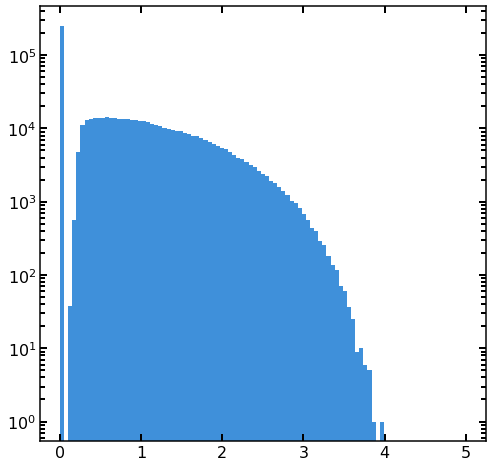

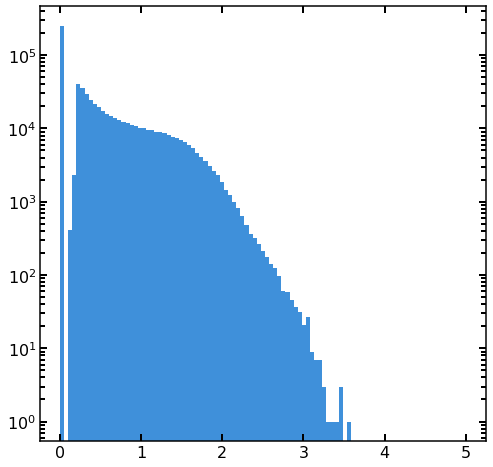

In [34]:
#file_dataset_orig = file_dataset
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/inputs/'
TRAIN_NAME = 'background_chan3_passed_ae_l1.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
file_dataset = np.array(in_file['dataset'][:,:,:])
file_dataset[:,:,2] = file_dataset[:,:,2]/1e5
file_dataset[:,:,3] = file_dataset[:,:,3]/1e5

n_proc = 3
(unique, counts) = np.unique(file_dataset[:,:,0], return_counts=True)
procs_sorted, counts_sorted = zip(*sorted(zip(unique, counts), key=lambda x: x[1],reverse=True))
top_proc_mask = np.isin(file_dataset[:,0,0], procs_sorted[:n_proc]) #choose top 3
file_dataset = file_dataset[top_proc_mask][:,1:12,:]
#file_dataset[:,:,2] = np.log(file_dataset[:,:,2]+1)
#file_dataset[:,:,3] = np.log(file_dataset[:,:,3]+1)

for i in [2,3]:
    bins = np.linspace(0,5,100)
    plt.figure(figsize=(8,8))
    out = np.log(file_dataset[:,:,i]+1)
    _ = plt.hist(out.reshape((out.shape[0]*out.shape[1])),bins=bins)
    plt.semilogy( )

In [71]:
def make_adjacencies(particles):
    real_p_mask = particles[:,:,1] > 0. # construct mask for real particles
    adjacencies = (real_p_mask[:,:,np.newaxis] * real_p_mask[:,np.newaxis,:]).astype('float32')
    return adjacencies

In [91]:
n_objs = 11
tot_evt =  file_dataset.shape[0]# int(1e4)
#connect all particles to all
adj_con = np.ones((n_objs,n_objs)) - np.eye(n_objs)
adj_connected = [csr_matrix(adj_orig)]*tot_evt
edge_index_connected = [from_scipy_sparse_matrix(a)[0] for a in adj_connected]

###connect only real particles 
adj_non_con = make_adjacencies(file_dataset)
adj_non_connected = [csr_matrix(adj_non_con[i]) for i in range(tot_evt)]
edge_index_non_connected = [from_scipy_sparse_matrix(a)[0] for a in adj_non_connected]      

In [94]:
edge_index_connected[1]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
          5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  2,  3,  4,  5,  6,  7,  8,
          9, 10,  0,  1,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  4,  5,  6,
          7,  8,  9, 10,  0,  1,  2,  3,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,
          4,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  7,  8,  9, 10,  0,  1,
          2,  3,  4,  5,  6,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  9, 10,
          0,  1,  2,  3,  4,  5,  6,  7,  8, 10,  0,  1,  2,  3,  4,  5,  6,  7,
          

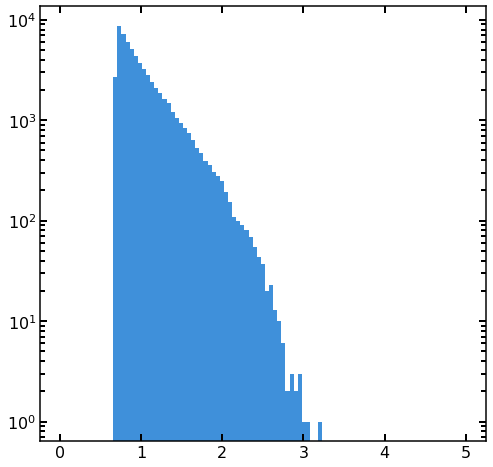

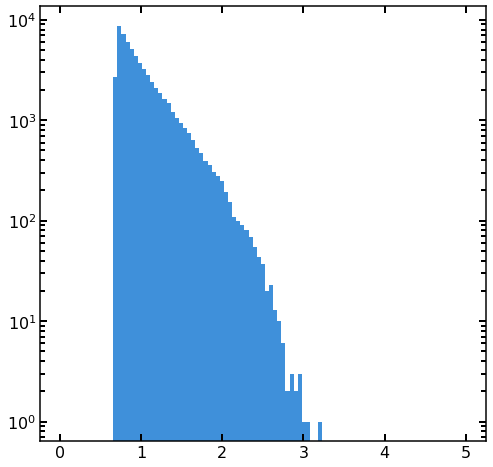

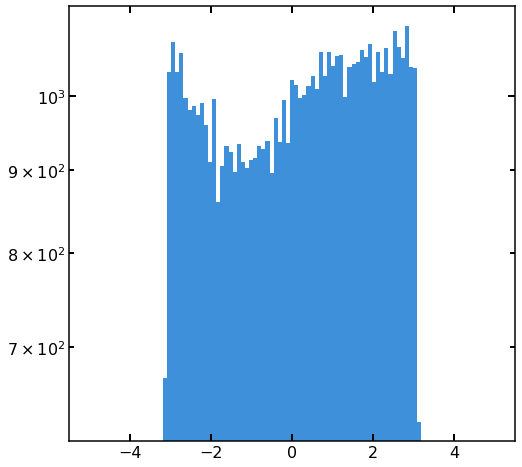

In [146]:
for i in [2,3,5]:
    bins = np.linspace(0,5,100)
    plt.figure(figsize=(8,8))
    #out = np.log(file_dataset[:,0,i]+1)
    out = file_dataset[:,0,i]
    if i==5:
        bins = np.linspace(-5,5,100)
    _ = plt.hist(out,bins=bins)
    plt.semilogy( )

In [186]:
m = pred_features_met.reshape((pred_features_met.shape[0]*pred_features_met.shape[1],pred_features_met.shape[2]))

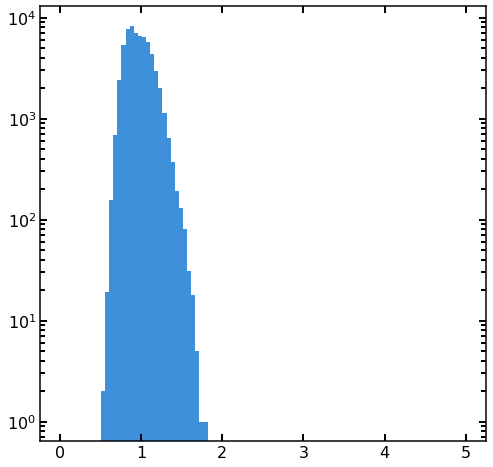

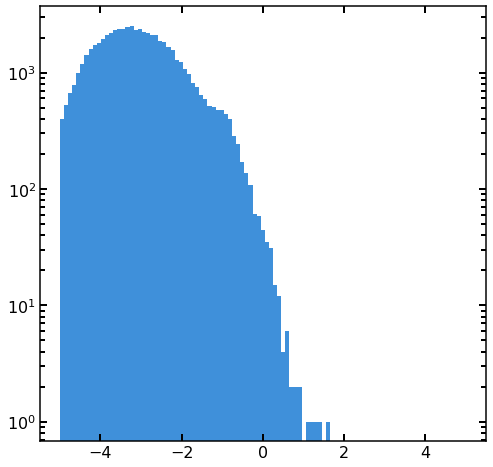

In [192]:
for i in [0,1]:
    bins = np.linspace(0,5,100)
    plt.figure(figsize=(8,8))
    #out = np.log(file_dataset[:,0,i]+1)
    out = m[:,i]
    if i==1:
        bins = np.linspace(-5,5,100)
    _ = plt.hist(out,bins=bins)
    plt.semilogy( )

In [191]:
m

array([[ 1.0275152 , -3.204226  ],
       [ 1.1132095 , -1.575401  ],
       [ 0.9468813 , -2.4342575 ],
       ...,
       [ 1.2499101 , -2.5381207 ],
       [ 1.0366473 , -1.8779249 ],
       [ 0.80001277, -3.086306  ]], dtype=float32)